In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# import data
aapl = pd.read_csv("Data/AAPL.csv")
spy = pd.read_csv("Data/SPY.csv")

data = pd.merge(aapl, spy, how='outer', on='Date')
data = data[["Adj Close_x", "Adj Close_y"]]
data = data.rename(columns={"Adj Close_x":"AAPL", "Adj Close_y":"SPY"})
data.head()

,AAPL,SPY
0,0.120388,NaN
1,0.117771,NaN
2,0.112536,NaN
3,0.107739,NaN
4,0.105558,NaN


Vectorized solution time: 0:00:00.106571


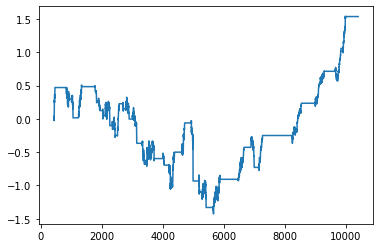

In [3]:
d = data.copy()

v_t1 = datetime.datetime.now()

d['Signals'] = (np.sign(d['AAPL'].rolling(20).mean() - d['AAPL'].rolling(200).mean())+1)/2
d['rets'] = d['AAPL'].pct_change()
d['Strat rets'] = d['rets'].shift(-1)*d['Signals']
d['Strat Rets Cumulative'] = d['Strat rets'].cumsum()
d['Reset Trade'] = np.sign(d['Signals'].diff())
d["Trade Entry"] = (d['Strat Rets Cumulative']*d['Reset Trade'].where(d['Reset Trade']==1)).ffill()
d['Trade PL'] = (d['Strat Rets Cumulative'] - d['Trade Entry'])*d['Signals']
d['Chopped PL'] = d['Trade PL'].copy()
d['Chopped PL'] = (-(np.sign(d['Chopped PL'].where(d['Chopped PL']>0.5)).fillna(0).diff().replace(0, np.nan)+1)/2).fillna(0)
d['Strat Signals + Take Profit'] = ((d['Signals'].diff() + d['Chopped PL']).replace(0, np.nan).ffill()+1)/2
d["Trade PL With Stop"] = (d['rets'].shift(-1)*d['Strat Signals + Take Profit']).cumsum()

v_t2 = datetime.datetime.now()
      
print("Vectorized solution time: {}".format(v_t2-v_t1))

plt.plot(d['Trade PL With Stop'])
plt.show()

Looped solution time: 0:00:01.790052


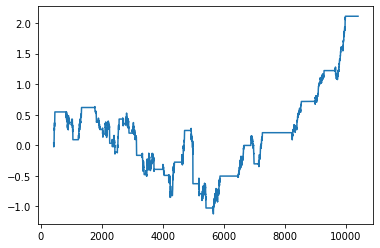

In [7]:
d_2 = data.copy()

l_t1 = datetime.datetime.now()

d_2['20 MA'] = d_2['AAPL'].rolling(20).mean().fillna(0)
d_2['200 MA'] = d_2['AAPL'].rolling(200).mean().fillna(0)
d_2['Signal'] = d_2['20 MA'] - d_2['200 MA']
d_2['Returns'] = d_2['AAPL'].pct_change().shift(-1)
d_2['In Trade'] = np.nan
trade_ret = []
in_long = False
take_profit = 0.5
profit_taken = False
exit = 0
enter_long = 0
closed_long = False
for i in range(len(d_2)):
    if i < 200:
        continue
    if in_long:
        if np.cumsum(trade_ret)[-1] > take_profit:
            profit_taken = True
            in_long = False
            d_2.at[i, "In Trade"] = 0
            trade_ret=[]
        elif d_2.iloc[i]['Signal'] < exit:
            closed_Long = True
            in_long = False
            d_2.at[i, "In Trade"] = 0
            trade_ret=[]
        else:
            d_2.at[i, "In Trade"] = 1
            trade_ret.append(d_2.iloc[i]['Returns'])
    else:
        if profit_taken:
            if d_2.iloc[i]['Signal'] > enter_long:
                d_2.at[i, "In Trade"] = 0
                trade_ret=[]
            else:
                d_2.at[i, "In Trade"] = 0
                trade_ret=[]
                profit_taken = False
        elif d_2.iloc[i]['Signal'] > enter_long:
            d_2.at[i, "In Trade"] = 1
            entry_price = d_2.iloc[i]['AAPL']
            trade_ret.append(d_2.iloc[i]['Returns'])
            in_long = True
d_2['In Trade'].fillna(0)
d_2['Trade PL With Stop'] = (d_2['AAPL'].pct_change().shift(-1)*d_2['In Trade']).cumsum().ffill()

l_t2 = datetime.datetime.now()

print("Looped solution time: {}".format(l_t2-l_t1))

plt.plot(d_2['Trade PL With Stop'])
plt.show()

Speed increase: x16.8


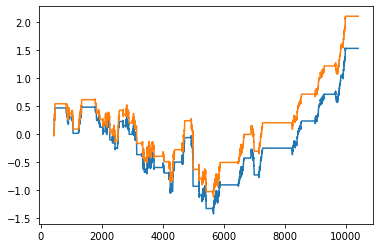

In [8]:
print("Speed increase: x{}".format(round(((l_t2-l_t1)/(v_t2-v_t1)), 2)))
plt.plot(d['Trade PL With Stop'])
plt.plot(d_2['Trade PL With Stop'])
plt.show()